Import dependencies

In [1]:
import pandas as pd
import numpy as np
import pickle

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

from keras.layers import Input, Dense
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.layers.merge import Concatenate

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Embedding, Bidirectional, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dropout
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import time

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Load the dataset from the original publication

In [3]:
DF_MRI = pd.read_excel(open('./datasets/Our Dataset 2.xlsx', 'rb'),
              sheet_name='Data organized fluoro-monomer')  

D:\anaconda\anaconda3\envs\copolymer\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  


In [4]:
DF_MRI

,VPA,QJ2,QJ3,FDH3,LX,ZDH1,T50
0,0.250000,0.000000,0.000000,0.750,0.0,0.0,514.145410
1,0.125000,0.375000,0.000000,0.500,0.0,0.0,462.956603
2,0.125000,0.250000,0.000000,0.625,0.0,0.0,492.524461
3,0.625000,0.250000,0.000000,0.125,0.0,0.0,392.557944
4,0.125000,0.625000,0.000000,0.250,0.0,0.0,633.486637
...,...,...,...,...,...,...,...
405,0.375311,0.224905,0.399743,0.000,0.0,0.0,529.627094
406,0.150548,0.150174,0.699326,0.000,0.0,0.0,518.735466
407,0.553503,0.262834,0.183610,0.000,0.0,0.0,588.056104
408,0.217890,0.151263,0.630883,0.000,0.0,0.0,618.300044


Construct the summary table

In [5]:
VPA = 'C=CP(=O)(O)O'
QJ2 = 'C=CC(=O)N'
QJ3 = 'C=CC(=O)NC(CO)(CO)CO'
FDH3 = 'CC(C)(CS(=O)(=O)O)NC(=O)C=C'
LX = 'CC(=C)C(=O)OCCOP(=O)([O-])OCC[N+](C)(C)C'
ZDH1 = 'C[N+](C)(C)CCOC(=O)C=C.[Cl-]'

In [6]:
Flag = [i != 'X' for i in DF_MRI['T50']]

In [7]:
DF_MRI[Flag]

,VPA,QJ2,QJ3,FDH3,LX,ZDH1,T50
0,0.250000,0.000000,0.000000,0.750,0.0,0.0,514.145410
1,0.125000,0.375000,0.000000,0.500,0.0,0.0,462.956603
2,0.125000,0.250000,0.000000,0.625,0.0,0.0,492.524461
3,0.625000,0.250000,0.000000,0.125,0.0,0.0,392.557944
4,0.125000,0.625000,0.000000,0.250,0.0,0.0,633.486637
...,...,...,...,...,...,...,...
405,0.375311,0.224905,0.399743,0.000,0.0,0.0,529.627094
406,0.150548,0.150174,0.699326,0.000,0.0,0.0,518.735466
407,0.553503,0.262834,0.183610,0.000,0.0,0.0,588.056104
408,0.217890,0.151263,0.630883,0.000,0.0,0.0,618.300044


In [8]:
Dataset_2 = DF_MRI[Flag].copy()

In [9]:
Dataset_2['Smiles'] = np.nan
for i in range(len(Dataset_2)):
    smi = 'C'
    if Dataset_2.loc[i, 'VPA'] > 0:
        smi = smi + '.C=CP(=O)(O)O'
    if Dataset_2.loc[i, 'QJ2'] > 0:
        smi = smi + '.C=CC(=O)N'
    if Dataset_2.loc[i, 'QJ3'] > 0:
        smi = smi + '.C=CC(=O)NC(CO)(CO)CO'
    if Dataset_2.loc[i, 'FDH3'] > 0:
        smi = smi + '.CC(C)(CS(=O)(=O)O)NC(=O)C=C'
    if Dataset_2.loc[i, 'LX'] > 0:
        smi = smi + '.CC(=C)C(=O)OCCOP(=O)([O-])OCC[N+](C)(C)C'
    if Dataset_2.loc[i, 'ZDH1'] > 0:
        smi = smi + '.C[N+](C)(C)CCOC(=O)C=C.[Cl-]'
    Dataset_2.loc[i, 'Smiles'] = smi

In [10]:
Dataset_2

,VPA,QJ2,QJ3,FDH3,LX,ZDH1,T50,Smiles
0,0.250000,0.000000,0.000000,0.750,0.0,0.0,514.145410,C.C=CP(=O)(O)O.CC(C)(CS(=O)(=O)O)NC(=O)C=C
1,0.125000,0.375000,0.000000,0.500,0.0,0.0,462.956603,C.C=CP(=O)(O)O.C=CC(=O)N.CC(C)(CS(=O)(=O)O)NC(...
2,0.125000,0.250000,0.000000,0.625,0.0,0.0,492.524461,C.C=CP(=O)(O)O.C=CC(=O)N.CC(C)(CS(=O)(=O)O)NC(...
3,0.625000,0.250000,0.000000,0.125,0.0,0.0,392.557944,C.C=CP(=O)(O)O.C=CC(=O)N.CC(C)(CS(=O)(=O)O)NC(...
4,0.125000,0.625000,0.000000,0.250,0.0,0.0,633.486637,C.C=CP(=O)(O)O.C=CC(=O)N.CC(C)(CS(=O)(=O)O)NC(...
...,...,...,...,...,...,...,...,...
405,0.375311,0.224905,0.399743,0.000,0.0,0.0,529.627094,C.C=CP(=O)(O)O.C=CC(=O)N.C=CC(=O)NC(CO)(CO)CO
406,0.150548,0.150174,0.699326,0.000,0.0,0.0,518.735466,C.C=CP(=O)(O)O.C=CC(=O)N.C=CC(=O)NC(CO)(CO)CO
407,0.553503,0.262834,0.183610,0.000,0.0,0.0,588.056104,C.C=CP(=O)(O)O.C=CC(=O)N.C=CC(=O)NC(CO)(CO)CO
408,0.217890,0.151263,0.630883,0.000,0.0,0.0,618.300044,C.C=CP(=O)(O)O.C=CC(=O)N.C=CC(=O)NC(CO)(CO)CO


Feature engineering with Morgan fingerprint

In [11]:
MOL = pd.DataFrame(['C=CP(=O)(O)O',
'C=CC(=O)N',
'C=CC(=O)NC(CO)(CO)CO',
'CC(C)(CS(=O)(=O)O)NC(=O)C=C',
'CC(=C)C(=O)OCCOP(=O)([O-])OCC[N+](C)(C)C',
'C[N+](C)(C)CCOC(=O)C=C.[Cl-]'])[0].apply(Chem.MolFromSmiles)

In [12]:
fp_1 = MOL.apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))
fp_1_n = fp_1.apply(lambda m: m.GetNonzeroElements())

In [13]:
# using substructures in dataset-1 to construct a dictionary
HashCode = []
for i in fp_1_n:
    for j in i.keys():
        HashCode.append(j)

unique_set = set(HashCode)
unique_list = list(unique_set)

Corr_df = pd.DataFrame(unique_list).reset_index()

In [14]:
#construct dataset-1 input
MY_finger = []
for polymer in fp_1_n:
    my_finger = [0] * len(unique_list)
    for key in polymer.keys():
        index = Corr_df[Corr_df[0] == key]['index'].values[0]
        my_finger[index] = polymer[key]
    MY_finger.append(my_finger)

MY_finger_dataset = pd.DataFrame(MY_finger)  

In [15]:
MY_finger_dataset

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,3,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,2,0,1,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,3,0,4,1,0,...,0,0,2,1,1,0,1,0,1,1
5,0,0,0,0,1,1,0,3,0,0,...,1,0,0,0,0,0,0,1,0,0


In [16]:
# filter input into the most popular 124 substructures
Zero_Sum = (MY_finger_dataset == 0).astype(int).sum()
NumberOfZero = 6
print(len(Zero_Sum[Zero_Sum < NumberOfZero]))
X = MY_finger_dataset[Zero_Sum[Zero_Sum < NumberOfZero].index]

94


In [17]:
X

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,3,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,2,0,1,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,3,0,4,1,0,...,0,0,2,1,1,0,1,0,1,1
5,0,0,0,0,1,1,0,3,0,0,...,1,0,0,0,0,0,0,1,0,0


Data Fusion

In [18]:
Mix_X = []
for i in range(len(DF_MRI[Flag])):
    Mix_X.append(X.iloc[0].values * DF_MRI[Flag]['VPA'].iloc[i] + \
                 X.iloc[1].values * DF_MRI[Flag]['QJ2'].iloc[i] + \
                 X.iloc[2].values * DF_MRI[Flag]['QJ3'].iloc[i] + \
                 X.iloc[3].values * DF_MRI[Flag]['FDH3'].iloc[i] + \
                 X.iloc[4].values * DF_MRI[Flag]['LX'].iloc[i] + \
                 X.iloc[5].values * DF_MRI[Flag]['ZDH1'].iloc[i])
Mix_X = np.array(Mix_X)

In [19]:
Mix_X.shape

(410, 94)

In [20]:
Mix_X_100Block = []
for i in range(len(DF_MRI[Flag])):
        random.seed(10)

        Random_position = []
        Random_position_all = []

        Rest = range(0, 100)
        for col in ['VPA', 'QJ2', 'QJ3', 'FDH3', 'LX', 'ZDH1']:

            X_random_position = random.sample(Rest, int(DF_MRI[Flag][col].iloc[i] * 100))
            Random_position.append(X_random_position)
            for p in X_random_position:
                Random_position_all.append(p)
            Rest = []
            for x in range(0, 100):
                if x not in Random_position_all:
                    Rest.append(x)
        
        Sequency_X = [0 for a in range(100)]
        for j in range(100):
            if j in Random_position[0]:
                Sequency_X[j] = 0
            elif j in Random_position[1]:
                Sequency_X[j] = 1
            elif j in Random_position[2]:
                Sequency_X[j] = 2
            elif j in Random_position[3]:
                Sequency_X[j] = 3
            elif j in Random_position[4]:
                Sequency_X[j] = 4
            elif j in Random_position[5]:
                Sequency_X[j] = 5
                
        Mix_X_100Block.append(Sequency_X)   

Mix_X_100Block = np.array(Mix_X_100Block)

In [21]:
Mix_X_100Block.shape

(410, 100)

In [22]:
Mix_X_100Block = Mix_X_100Block.reshape((410, 100, 1))
Mix_X_100Block.shape

(410, 100, 1)

In [23]:
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.layers.merge import Concatenate
from numpy.random import seed
import tensorflow

In [24]:
from keras.layers import Input, Dense, concatenate, Bidirectional, LSTM, TimeDistributed, Reshape
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np

In [25]:
LSTMunits = 20

In [26]:
# Define two sets of inputs
inputA = Input(shape=(100, 1))
inputB = Input(shape=(94,))

# The first branch operates on the first input
RNNmodel = Bidirectional(LSTM(LSTMunits, return_sequences=True))(inputA)
RNNmodel = Bidirectional(LSTM(LSTMunits, return_sequences=True))(RNNmodel)
RNNmodel = TimeDistributed(Dense(int(LSTMunits / 2), activation="relu"))(RNNmodel)
RNNmodel = Reshape((int(LSTMunits / 2 * 100),))(RNNmodel)

# The second branch operates on the second input
y = Dense(8, activation="relu")(inputB)
y = Dense(8, activation="relu")(y)
y = Dense(int(LSTMunits / 2 * 100), activation="relu", dtype='float32')(y)

# Combine the output of the two branches
combined = concatenate([RNNmodel, y], dtype='float32')

# Apply a FC layer and then a regression prediction on the combined outputs
z = Dense(8, activation="relu")(combined)
z = Dense(1, activation="linear")(z)

# Our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[inputA, inputB], outputs=z)


xtrain_B, xtest_B, ytrain_B, ytest_B=train_test_split(Mix_X, DF_MRI[Flag]['T50'].astype(np.float64), test_size=0.20, random_state=200)
xtrain_A, xtest_A, ytrain_A, ytest_A=train_test_split(Mix_X_100Block, DF_MRI[Flag]['T50'].astype(np.float64), test_size=0.20, random_state=200)

model.compile(optimizer='adam',  # 使用字符串标识符 'adam'
              loss="mean_squared_error",
              metrics=["mean_squared_error"])

Model = model.fit(
    x=[xtrain_A, xtrain_B], y=ytrain_B,
    validation_data=([xtest_A, xtest_B], ytest_B),
    epochs=300, batch_size=25, verbose=2) #epochs=100, batch_size=128, verbose=2)

Epoch 1/300
14/14 - 18s - loss: 299598.0625 - mean_squared_error: 299598.0625 - val_loss: 288858.3750 - val_mean_squared_error: 288858.3750
Epoch 2/300
14/14 - 0s - loss: 283916.4375 - mean_squared_error: 283916.4375 - val_loss: 258509.7344 - val_mean_squared_error: 258509.7344
Epoch 3/300
14/14 - 0s - loss: 237481.7344 - mean_squared_error: 237481.7344 - val_loss: 188534.5312 - val_mean_squared_error: 188534.5312
Epoch 4/300
14/14 - 0s - loss: 150200.8125 - mean_squared_error: 150200.8125 - val_loss: 88428.3438 - val_mean_squared_error: 88428.3438
Epoch 5/300
14/14 - 0s - loss: 56315.2812 - mean_squared_error: 56315.2812 - val_loss: 18775.5957 - val_mean_squared_error: 18775.5957
Epoch 6/300
14/14 - 0s - loss: 18740.4453 - mean_squared_error: 18740.4473 - val_loss: 19298.8652 - val_mean_squared_error: 19298.8652
Epoch 7/300
14/14 - 0s - loss: 18265.1836 - mean_squared_error: 18265.1836 - val_loss: 15207.1523 - val_mean_squared_error: 15207.1523
Epoch 8/300
14/14 - 0s - loss: 15876.418

Epoch 62/300
14/14 - 0s - loss: 13947.7637 - mean_squared_error: 13947.7637 - val_loss: 13926.4463 - val_mean_squared_error: 13926.4463
Epoch 63/300
14/14 - 0s - loss: 13934.7656 - mean_squared_error: 13934.7656 - val_loss: 13887.8477 - val_mean_squared_error: 13887.8477
Epoch 64/300
14/14 - 0s - loss: 14257.6299 - mean_squared_error: 14257.6299 - val_loss: 13876.4287 - val_mean_squared_error: 13876.4287
Epoch 65/300
14/14 - 0s - loss: 14197.6445 - mean_squared_error: 14197.6445 - val_loss: 13968.3662 - val_mean_squared_error: 13968.3662
Epoch 66/300
14/14 - 0s - loss: 14113.4941 - mean_squared_error: 14113.4941 - val_loss: 13959.9980 - val_mean_squared_error: 13959.9980
Epoch 67/300
14/14 - 0s - loss: 13906.3154 - mean_squared_error: 13906.3154 - val_loss: 13932.1611 - val_mean_squared_error: 13932.1611
Epoch 68/300
14/14 - 0s - loss: 13928.8447 - mean_squared_error: 13928.8447 - val_loss: 13918.7197 - val_mean_squared_error: 13918.7197
Epoch 69/300
14/14 - 0s - loss: 13906.8291 - mea

14/14 - 0s - loss: 13311.5215 - mean_squared_error: 13311.5215 - val_loss: 13237.6143 - val_mean_squared_error: 13237.6143
Epoch 123/300
14/14 - 0s - loss: 13374.3418 - mean_squared_error: 13374.3418 - val_loss: 13021.0811 - val_mean_squared_error: 13021.0811
Epoch 124/300
14/14 - 0s - loss: 13427.7637 - mean_squared_error: 13427.7637 - val_loss: 12954.4561 - val_mean_squared_error: 12954.4541
Epoch 125/300
14/14 - 0s - loss: 13246.2451 - mean_squared_error: 13246.2451 - val_loss: 12984.0459 - val_mean_squared_error: 12984.0459
Epoch 126/300
14/14 - 0s - loss: 13155.2695 - mean_squared_error: 13155.2695 - val_loss: 12973.0869 - val_mean_squared_error: 12973.0869
Epoch 127/300
14/14 - 0s - loss: 13134.9893 - mean_squared_error: 13134.9893 - val_loss: 12966.6553 - val_mean_squared_error: 12966.6553
Epoch 128/300
14/14 - 0s - loss: 13115.4316 - mean_squared_error: 13115.4316 - val_loss: 12950.7393 - val_mean_squared_error: 12950.7393
Epoch 129/300
14/14 - 0s - loss: 13158.9834 - mean_squa

Epoch 182/300
14/14 - 0s - loss: 12858.4434 - mean_squared_error: 12858.4434 - val_loss: 12524.2617 - val_mean_squared_error: 12524.2617
Epoch 183/300
14/14 - 0s - loss: 12840.2852 - mean_squared_error: 12840.2861 - val_loss: 12654.7959 - val_mean_squared_error: 12654.7959
Epoch 184/300
14/14 - 0s - loss: 12961.6064 - mean_squared_error: 12961.6064 - val_loss: 12783.1514 - val_mean_squared_error: 12783.1514
Epoch 185/300
14/14 - 0s - loss: 12877.1221 - mean_squared_error: 12877.1221 - val_loss: 12710.9736 - val_mean_squared_error: 12710.9736
Epoch 186/300
14/14 - 0s - loss: 13020.1611 - mean_squared_error: 13020.1631 - val_loss: 12761.5078 - val_mean_squared_error: 12761.5078
Epoch 187/300
14/14 - 0s - loss: 12932.8975 - mean_squared_error: 12932.8975 - val_loss: 12744.0928 - val_mean_squared_error: 12744.0928
Epoch 188/300
14/14 - 0s - loss: 12835.2031 - mean_squared_error: 12835.2031 - val_loss: 12783.0322 - val_mean_squared_error: 12783.0322
Epoch 189/300
14/14 - 0s - loss: 13011.37

Epoch 242/300
14/14 - 0s - loss: 12954.5889 - mean_squared_error: 12954.5889 - val_loss: 12791.3184 - val_mean_squared_error: 12791.3184
Epoch 243/300
14/14 - 0s - loss: 12819.5947 - mean_squared_error: 12819.5947 - val_loss: 12618.5400 - val_mean_squared_error: 12618.5400
Epoch 244/300
14/14 - 0s - loss: 12840.7178 - mean_squared_error: 12840.7178 - val_loss: 12267.0439 - val_mean_squared_error: 12267.0439
Epoch 245/300
14/14 - 0s - loss: 12770.9219 - mean_squared_error: 12770.9219 - val_loss: 12532.8838 - val_mean_squared_error: 12532.8838
Epoch 246/300
14/14 - 0s - loss: 12809.9736 - mean_squared_error: 12809.9736 - val_loss: 12438.0117 - val_mean_squared_error: 12438.0117
Epoch 247/300
14/14 - 0s - loss: 12679.8965 - mean_squared_error: 12679.8965 - val_loss: 12522.1719 - val_mean_squared_error: 12522.1719
Epoch 248/300
14/14 - 0s - loss: 12817.2031 - mean_squared_error: 12817.2031 - val_loss: 12627.4668 - val_mean_squared_error: 12627.4668
Epoch 249/300
14/14 - 0s - loss: 13055.66

In [27]:
with open('Fusion_Loss.pickle', 'wb') as handle:
    pickle.dump(Model.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
Model.history = pickle.load(open("Fusion_Loss.pickle","rb"))

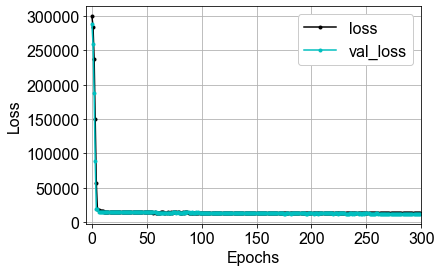

In [29]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs = len(loss)
plt.xlim((-5, 300))
plt.plot(range(epochs), loss, color = 'k', marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, color = 'c', marker = '.', label = 'val_loss')
plt.xticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.yticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.legend(loc = 'best', framealpha=1, prop={'size': 16, 'family':"Arial"})

plt.grid()
plt.xlabel('Epochs',fontname="Arial", fontsize=16)
plt.ylabel('Loss',fontname="Arial", fontsize=16)
plt.savefig("Fusion_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

In [30]:
filepath = 'MRI_FusionModel.model'
save_model(model, filepath, save_format='h5')

In [31]:
model = load_model('MRI_FusionModel.model')

In [32]:
y_train = ytrain_B
y_test = ytest_B

y_pred_train = model.predict([xtrain_A, xtrain_B])
print("Train set R^2: ", r2_score(y_train, y_pred_train))

y_pred_test = model.predict([xtest_A, xtest_B])
print("Test set R^2: ", r2_score(y_test, y_pred_test))

Train set R^2:  0.15571074420387965
Test set R^2:  0.16329392058730674


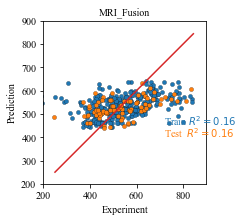

In [33]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 600
x_start, x_end = 250, 850
plt.xlim([200, 900])
plt.ylim([200, 900])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(720, 450, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(720, 400, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_Fusion',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_FusionModel.png", dpi=1200, bbox_inches='tight') 